In [1]:
import os
import mat73
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from scipy.signal import butter, filtfilt, find_peaks
from mat73 import loadmat as ldt

import matplotlib.pyplot as plt
from scipy.stats import zscore
from functools import lru_cache

from __future__ import annotations
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional, Iterable

import numpy as np
import pandas as pd
from scipy.signal import welch
from scipy.optimize import curve_fit
from scipy.stats import skew, kurtosis

## Load personal written functions here
from compute_dff import compute_dff
from denoise_dff import denoise_dff
from detect_events import detect_events
from detect_events_stim_aligned import detect_events_stim_aligned
from summarize_event_metrics_by_class import summarize_event_metrics_by_class
from compute_tonic_metrics import compute_tonic_metrics
from compute_clearance_metrics import clearance_metrics_by_class
from excitability_metrics_by_class import excitability_metrics_by_class
from network_reorg import network_reorg_metrics_and_plots
from extract_rois import extract_signal_by_stimulus
from network_reorg_metrics_and_plots_responsive import network_reorg_metrics_and_plots_responsive


## Figure formatting starts here
sns.set_theme(style="darkgrid")
plt.rcParams['font.family'] = 'DejaVu Sans'

## Silence the warnings about NAN later in the notebook
## They do not affect the running of the script but continue to overload the notebook with lengthy unhelpful warnings
## I will fix these later
import warnings
warnings.filterwarnings('ignore')

In [ ]:
## Path to files
wt = "/Users/gwk/Desktop/CalciumImaging/Wt_Unexposed/f1/gmrxanat.mat"
wt7dpf = "/Users/gwk/Desktop/CalciumImaging/Wt_Unexposed/f2/gmrxanat.mat"
wte = "/Users/gwk/Desktop/CalciumImaging/Wt_exposed/f2/gmrxanat.mat"
mute = "/Users/gwk/Desktop/CalciumImaging/Mut_exposed/f1/gmrxanat.mat"
mute7dpf1 = "/Users/gwk/Desktop/CalciumImaging/Mut_exposed/7_dpf/f1/gmrxanat.mat"
mute7dpf3 = "/Users/gwk/Desktop/CalciumImaging/Mut_exposed/7_dpf/f3/gmrxanat.mat"
mute7dpf2 = "/Users/gwk/Desktop/CalciumImaging/Mut_exposed/7_dpf/f2/gmrxanat.mat"

In [18]:
@lru_cache(maxsize=50)
def import_2p_data(path_to_file_of_interest):
    df = mat73.loadmat(path_to_file_of_interest)
    return df

In [2]:
def sanitize_roi_matrix(X):
    import numpy as np, pandas as pd
    df = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
    bad = ~np.isfinite(df.values).any(axis=0)
    if bad.any():
        print("Dropping all-NaN ROIs:", list(df.columns[bad]))
        df = df.loc[:, ~bad]
    return df

In [19]:
wt_unexp = import_2p_data(wt)
wt_unexp2 = import_2p_data(wt7dpf)
wt_exp = import_2p_data(wte)
mut_exp = import_2p_data(mute)
mut_exp2 = import_2p_data(mute7dpf1)
mut_exp3 = import_2p_data(mute7dpf2)
mut_exp4 = import_2p_data(mute7dpf3)

In [107]:
unexposed_wt2 = extract_signal_by_stimulus(wt_unexp2, stim=3)
unexposed_wt = extract_signal_by_stimulus(wt_unexp, stim=3)
exposed_wt = extract_signal_by_stimulus(wt_exp, stim=3)
exposed_mut2 = extract_signal_by_stimulus(mut_exp2, stim=3)
exposed_mut = extract_signal_by_stimulus(mut_exp, stim=3)
exposed_mut3 = extract_signal_by_stimulus(mut_exp3, stim=3)
exposed_mut4 = extract_signal_by_stimulus(mut_exp4, stim=3)

Once all the files to be analysed have been uploaded. I extract the ROIs into a data frame with (Frames x ROIs)
This dataframe is then used for downstream analysis

In [120]:
#data_frame = pd.DataFrame(exposed_mut4).transpose()
#data_frame.to_csv(f'./data/traces.csv', index=False)

In [121]:
#data_frame.to_csv('./extractedROI/loomFrontal/exposed_mut4.csv')

In [3]:
unexposed_wt = pd.read_csv('./extractedROI/loomROI/unexposed_wt.csv', index_col=0)
unexposed_wt2 = pd.read_csv('./extractedROI/loomROI/unexposed_wt2.csv', index_col=0)
exposed_wt = pd.read_csv('./extractedROI/loomROI/exposed_wt.csv', index_col=0)
exposed_mut1 = pd.read_csv('./extractedROI/loomROI/exposed_mut1.csv', index_col=0)
exposed_mut2 = pd.read_csv('./extractedROI/loomROI/exposed_mut2.csv', index_col=0)
exposed_mut3 = pd.read_csv('./extractedROI/loomROI/exposed_mut3.csv', index_col=0)
exposed_mut4 = pd.read_csv('./extractedROI/loomROI/exposed_mut4.csv', index_col=0)

Having the ROIs, I compute the deltaF/F while maintaining the structure of the data frame here 

In [9]:
dff, f0 = compute_dff(
    exposed_wt,                     # or a numpy array
    fs=3.6,                 # your sampling rate
    baseline_percentile=20, # robust lower-percentile
    window_seconds=50,      # ~20 s window works well for 30 s recordings
    detrend="poly",         # set to None to disable detrend
    polyorder=1,            # linear detrend
    return_f0=True
)

After computing \Delta F/Fo, the signal is denoised to make it easier to detect calcium events. This step may be better ran outside of notebooks, where a deconvolution algorithm such as OASIS can be used to achieve this. However, here I use the Scipy Butterworth low-pass filter to achieve this, and it works, as can be seen in the figure below.

In [10]:
dff_smooth = denoise_dff(
    dff,
    fs=3.6,
    method="savgol",          # "butter" | "savgol" | "median" | "none"
    cutoff_hz=1.0,            # for Butterworth
    order=3,                  # Butterworth order
    hampel_window_seconds=3.0,# pre-outlier removal
    hampel_n_sigma=3.0,
    zscore_clip=6.0,          # optional final clipping
    preserve_nans=True
)

In [11]:
dff_cleaned = sanitize_roi_matrix(dff_smooth)

In [12]:
## Export the smoothed trace here 
#dff_smooth.to_csv('./preproccessedData/smoothed_roi.csv', index_label=None)

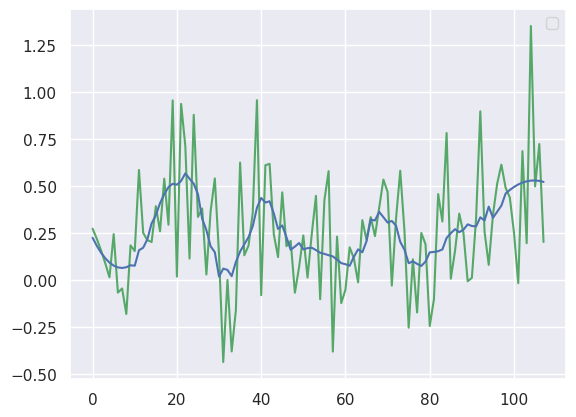

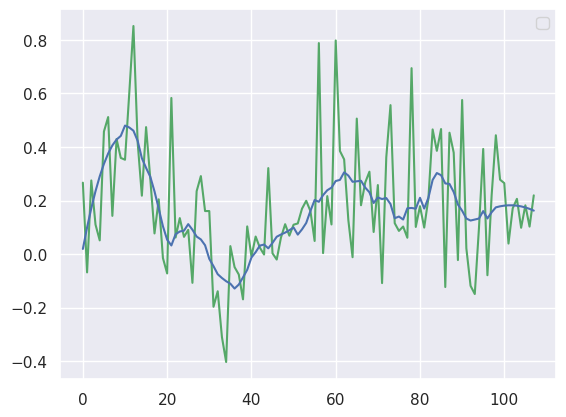

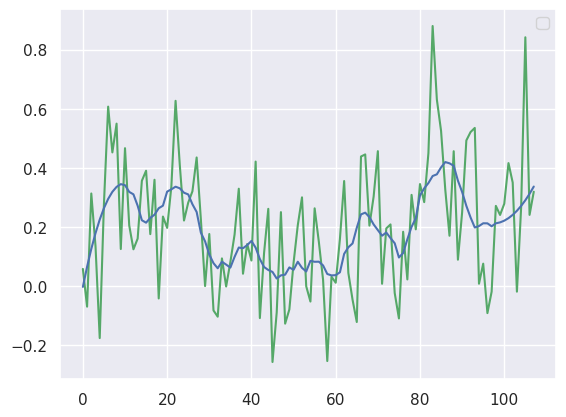

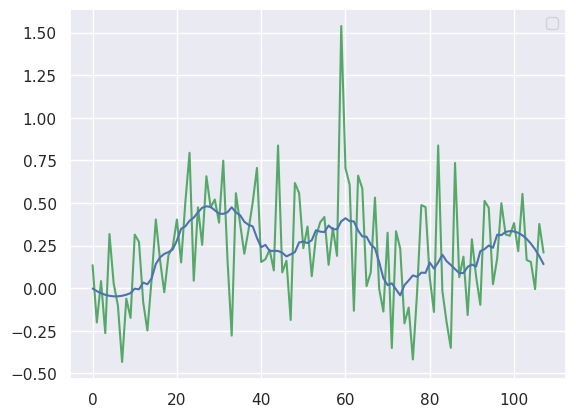

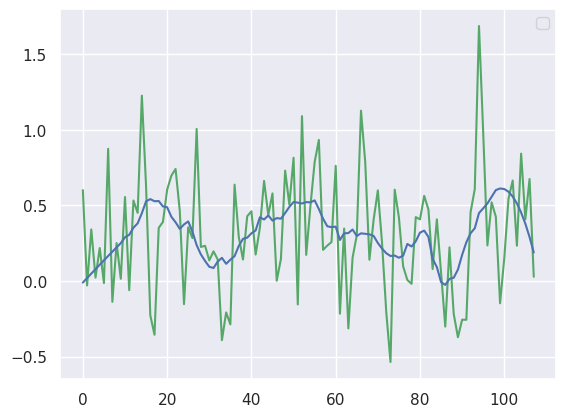

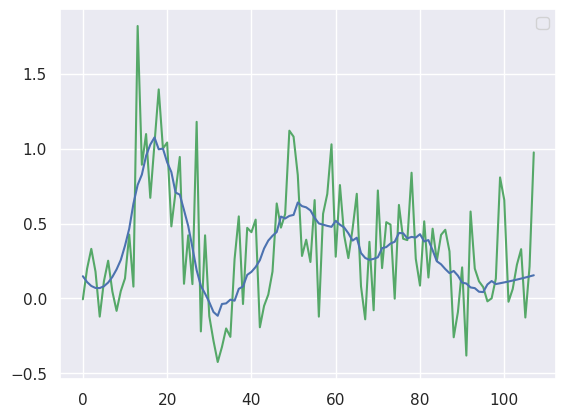

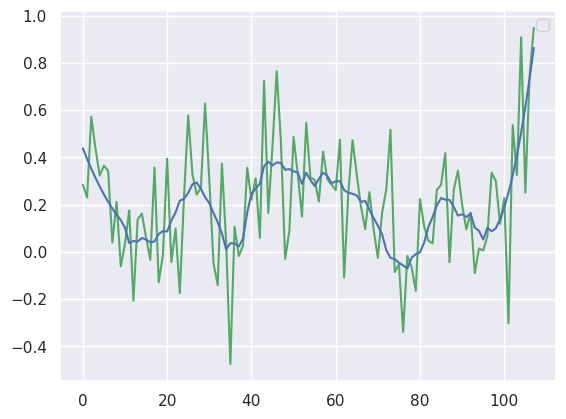

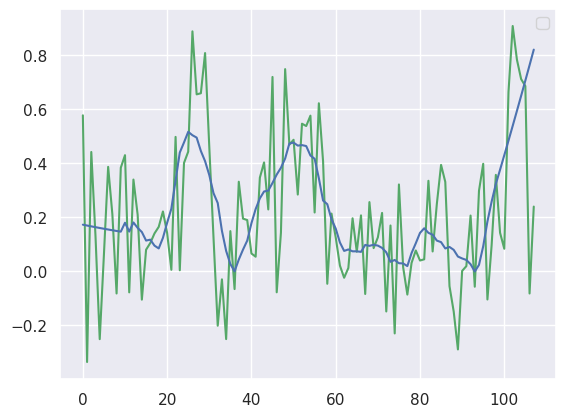

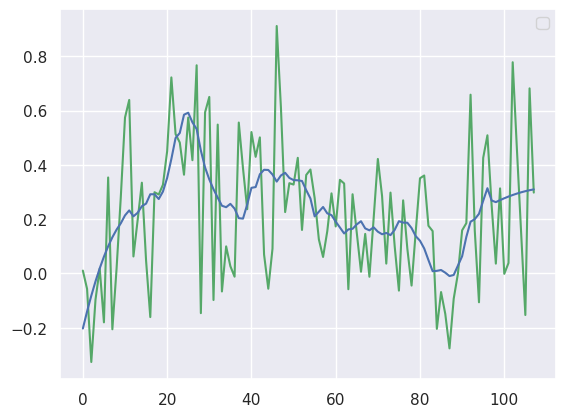

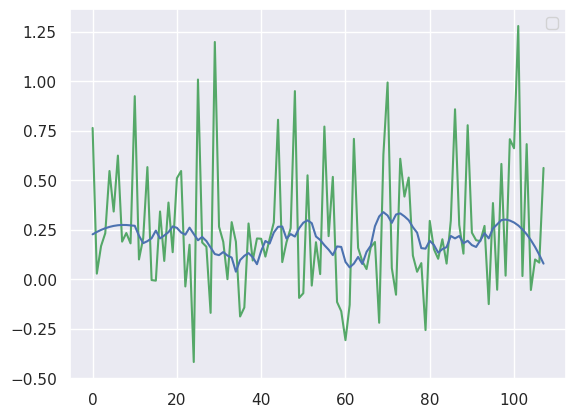

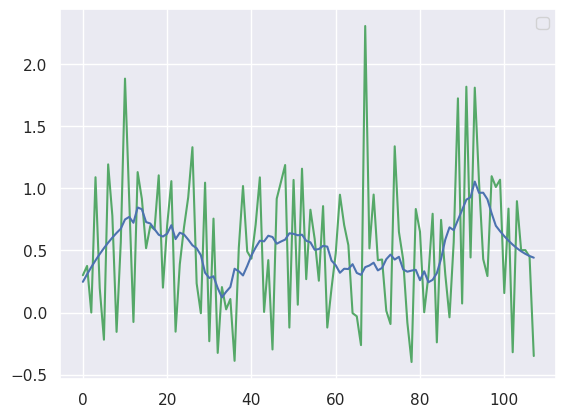

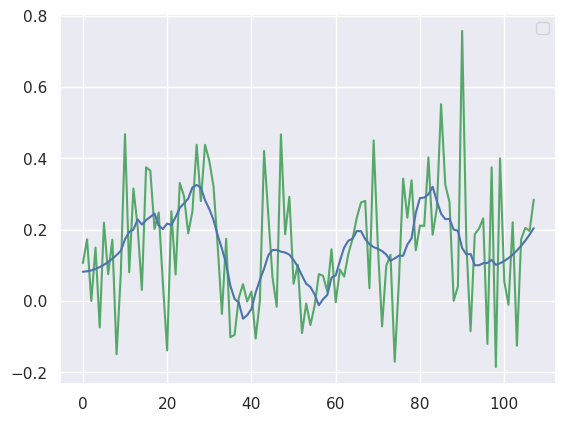

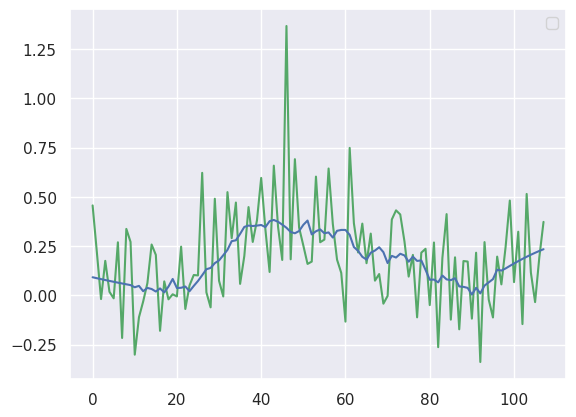

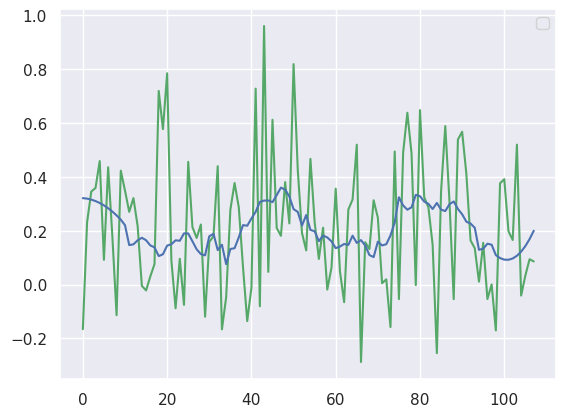

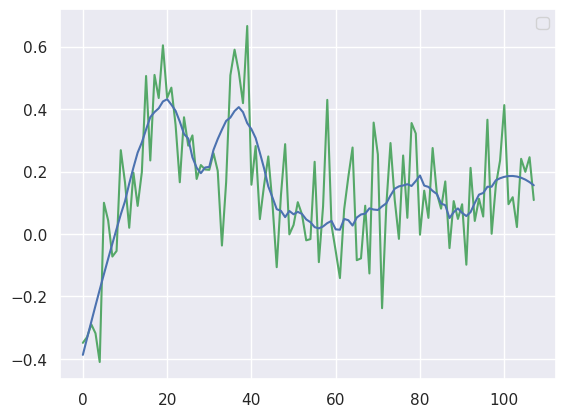

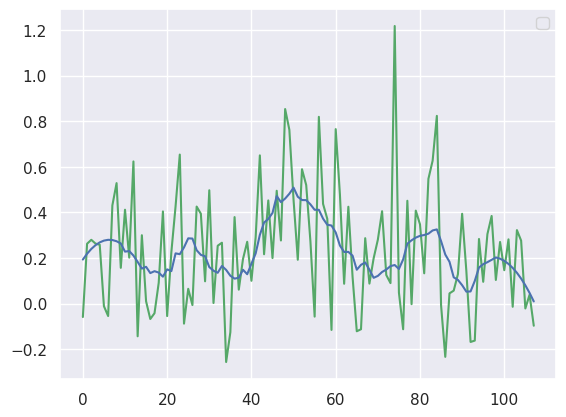

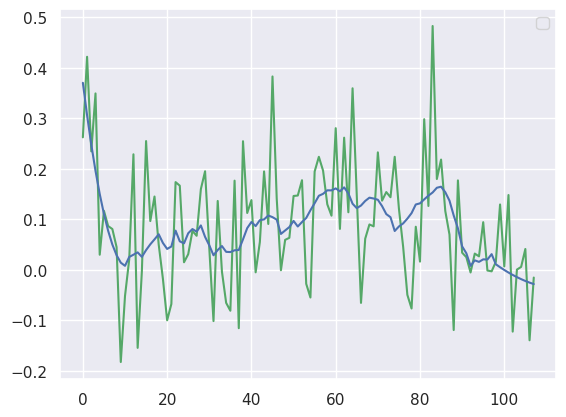

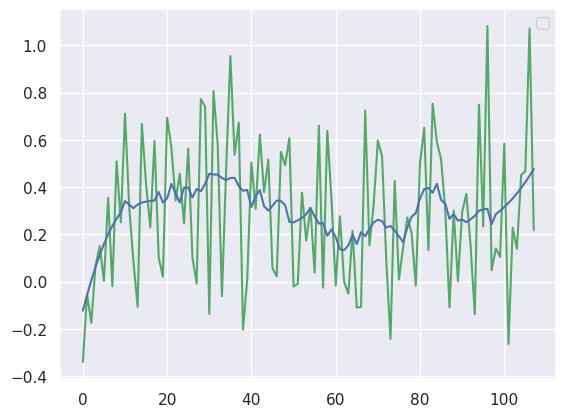

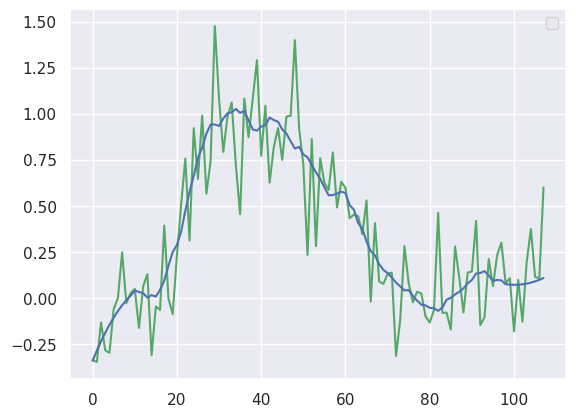

In [33]:
cell = '11'

for cell in range(1,20):
    plt.plot(dff[str(cell)], 'g-')
    plt.plot(dff_cleaned[str(cell)], 'b-')
    plt.legend()
    plt.show()

In [119]:
saveData = 'exposed_mut4'

In [120]:
# dff_smooth: denoised ΔF/F0 DataFrame (frames × ROIs)
tonic = compute_tonic_metrics(
    dff_cleaned,
    fs=3.6,
    baseline_percentile=20.0,  # running baseline = 20th percentile
    window_seconds=20.0,       # ≈72 frames at 3.6 Hz
    activity_z=2.0,            # "active" if residual > 2× robust σ
    save_path=f"./final_results/mutant_exposed/tonic_metrics_{saveData}.csv"  # set to None to skip saving
)

tonic.head()

,median_dff,duty_cycle,baseline_drift_s,baseline_drift_min,noise_sigma
ROI,,,,,
0,0.397834,0.120370,-0.002372,-0.142308,0.210458
1,0.252229,0.129630,0.000686,0.041149,0.094883
10,0.235702,0.083333,0.000103,0.006196,0.191317
100,0.222990,0.129630,0.004587,0.275221,0.066640
1000,0.152238,0.138889,-0.003312,-0.198749,0.109767


In [121]:
# dff_smooth: your denoised ΔF/F0 (frames × ROIs)
clearance = clearance_metrics_by_class(
    dff_cleaned,
    fs=3.6,
    # detection params (kept consistent with earlier steps)
    k_sigma_height=2.5,
    k_sigma_prom=2.0,
    min_distance_s=0.5,
    pre_window_s=2.0,
    post_window_s=4.0,
    merge_within_s=0.3,
    # class windows
    stim_frame=11,     # PRE: 0–11
    during_start=12,   # DURING: 12–50
    during_end=50,
    post_start=51,     # POST: 51–end
    # clearance definitions
    tail_seconds=4.0,        # AUC window after peak
    max_decay_seconds=8.0,   # search window for 1/e and T90
    baseline_z=1.0,          # baseline + z·σ threshold
    save_path=f"./final_results/mutant_exposed/clearance_metrics_by_class_{saveData}.csv"
)

clearance.head()
# CSV written to /mnt/data/clearance_metrics_by_class.csv

mean_decay_tau_1e_s  mean_t90_s  mean_time_to_baseline_s  \
ROI class                                                              
0   during             1.388889    1.388889                 1.111111   
    post               0.833333    1.111111                 0.555556   
    pre                     NaN         NaN                      NaN   
1   during                  NaN         NaN                      NaN   
    post               1.203704    2.037037                 0.740741   

            mean_tail_auc_s  n_events  responsive  
ROI class                                          
0   during        -0.152576         1        True  
    post          -0.369532         1        True  
    pre                 NaN         0       False  
1   during              NaN         0       False  
    post           0.029152         3        True

In [122]:
exc = excitability_metrics_by_class(
    dff_cleaned,
    fs=3.6,
    # detection params (same style as before)
    k_sigma_height=2.5,
    k_sigma_prom=2.0,
    min_distance_s=0.5,
    pre_window_s=2.0,
    post_window_s=4.0,
    merge_within_s=0.3,
    # windows
    stim_frame=11,    # PRE: 0–11
    during_start=12,  # DURING: 12–50
    during_end=50,
    post_start=51,    # POST: 51–end
    save_path=f"./final_results/mutant_exposed/excitability_metrics_by_class_{saveData}.csv"
)

exc.head(10)
# CSV written to /mnt/data/excitability_metrics_by_class.csv

mean_peak_amp  event_rate_hz  mean_IEI_s  median_IEI_s  \
ROI class                                                            
0   during       0.460880       0.092308         NaN           NaN   
    post         0.250715       0.063158         NaN           NaN   
    pre               NaN       0.000000         NaN           NaN   
1   during            NaN       0.000000         NaN           NaN   
    post         0.132707       0.189474    5.555556      5.555556   
    pre               NaN       0.000000         NaN           NaN   
10  during       0.166926       0.092308         NaN           NaN   
    post         0.221486       0.126316   11.388889     11.388889   
    pre               NaN       0.000000         NaN           NaN   
100 during       0.050444       0.092308         NaN           NaN   

            response_probability  n_events  
ROI class                                   
0   during                   1.0         1  
    post                     1.0         1  
    pre                      0.0         0  
1   during                   0.0         0  
    post                     1.0         3  
    pre                      0.0         0  
10  during                   1.0         1  
    post                     1.0         2  
    pre                      0.0         0  
100 during                   1.0         1

In [123]:
'''
# dff_smooth: frames × ROIs (ΔF/F0, denoised). Optional ROI coords:
# roi_coords = pd.DataFrame({"x": ..., "y": ...}, index=dff_smooth.columns)

out = network_reorg_metrics_and_plots(
    dff_cleaned,
    fs=3.6,
    # stimulus windows (PRE 0–11, DURING 12–50, POST 51–end)
    stim_frame=11, during_start=12, during_end=50, post_start=51,
    # low-frequency proxy (rolling mean window, seconds)
    lowpass_seconds=6.0,
    roi_coords=None,   # or pass your coords DataFrame
    save_prefix=f"./final_results/wt/network_reorg"
)

# Core summary table (per class: pre, during, post)
out
'''

'\n# dff_smooth: frames × ROIs (ΔF/F0, denoised). Optional ROI coords:\n# roi_coords = pd.DataFrame({"x": ..., "y": ...}, index=dff_smooth.columns)\n\nout = network_reorg_metrics_and_plots(\n    dff_cleaned,\n    fs=3.6,\n    # stimulus windows (PRE 0–11, DURING 12–50, POST 51–end)\n    stim_frame=11, during_start=12, during_end=50, post_start=51,\n    # low-frequency proxy (rolling mean window, seconds)\n    lowpass_seconds=6.0,\n    roi_coords=None,   # or pass your coords DataFrame\n    save_prefix=f"./final_results/wt/network_reorg"\n)\n\n# Core summary table (per class: pre, during, post)\nout\n'

In [124]:
pre_df, during_df, post_df = detect_events_stim_aligned(
    dff_cleaned,
    fs=3.6,
    k_sigma_height=2.5,   # peak height ≥ 2.5× robust sigma
    k_sigma_prom=2.0,     # prominence ≥ 2.0× robust sigma
    min_distance_s=0.5,   # ≥0.5 s at 3.6 Hz (GCaMP7s-aware)
    pre_window_s=2.0,     # for local baseline & onset
    post_window_s=4.0,    # for decay estimation window
    merge_within_s=0.3,   # merge peaks <0.3 s apart
    stim_frame=11,        # stimulus delivered at frame 11
    during_start=12,      # evoked window begins at frame 12
    during_end=50,        # ends at frame 50 (inclusive)
    post_start=51,        # start post at 51 to avoid overlap
    save_prefix=f"./final_results/mutant_exposed/stim_windows_{saveData}"
)

Saved ./final_results/mutant_exposed/stim_windows_exposed_mut4_pre.csv, ./final_results/mutant_exposed/stim_windows_exposed_mut4_during.csv, ./final_results/mutant_exposed/stim_windows_exposed_mut4_post.csv


In [125]:
during_df['roi'] = during_df.index
pre_df['roi'] = pre_df.index
post_df['roi'] = post_df.index

In [126]:
out = network_reorg_metrics_and_plots_responsive(
    dff_cleaned,                  # frames × ROIs ΔF/F0
    fs=3.6,
    pre_df=pre_df,                # each must have columns ['roi','responsive']
    during_df=during_df,
    post_df=post_df,
    save_prefix=f"./final_results/mutant_exposed/network_reorg_resp_{saveData}"
)
out["summary_by_class"]


,n_rois_used,mean_pairwise_r,pc1_var_fraction,effective_dimensionality,lowfreq_fraction_<0.10Hz
class,,,,,
during,7571,0.033210,0.749741,1.600662,0.563349
post,7151,0.011588,0.998906,1.002190,0.381221
pre,747,0.941335,1.000000,1.000000,0.000000


In [127]:
out_df = summarize_event_metrics_by_class(
    dff_cleaned,
    fs=3.6,
    k_sigma_height=2.5,  # adaptive height threshold (× robust sigma)
    k_sigma_prom=2.0,    # adaptive prominence threshold (× robust sigma)
    min_distance_s=0.5,  # min inter-peak distance (GCaMP7s-aware)
    pre_window_s=2.0,
    post_window_s=4.0,
    merge_within_s=0.3,
    stim_frame=11,
    during_start=12,
    during_end=50,
    post_start=51,
    # pre_df=pre_df, during_df=during_df, post_df=post_df,  # optional
    save_path=f"./final_results/mutant_exposed/event_metrics_by_class_{saveData}.csv"
)

Saved event metrics by class to: ./final_results/mutant_exposed/event_metrics_by_class_exposed_mut4.csv
